In [1]:
from observational_fear.utils import align_to_freeze
from pathlib import Path
import warnings
import pandas as pd 
import numpy as np
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.base import clone


DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")
session = "day4"

In [11]:
KFold(4).get_n_splits()

4

In [2]:
def set_same_num_freezes(real, fake):
    max_event = fake.groupby("mouse_name").event.max().min()
    return real.loc[lambda x: x.event < max_event], fake.loc[lambda x: x.event < max_event]

def get_offset(real, fake, offset):
    return real.loc[lambda x: x.aligned == offset], fake.loc[lambda x: x.aligned == offset]

def get_X_y(real, fake):
    real = real.pivot(index="event", columns="new_id", values="value")
    fake = fake.pivot(index="event", columns="new_id", values="value")
    X = pd.concat([real, fake]).reset_index(drop=True)
    y = pd.Series([1] * len(real) + [0] * len(fake))
    return X, y


def fit_model(pipe, X, y, k_folds=10):
    cv = KFold(n_splits=k_folds, shuffle=True)
    return cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro")

In [3]:
def fit_decoder(
    data_dir, session, start_stop, pipe, t_before=5, t_after=5, k_folds=10, n_boot=75
):
    min_freeze_diff = t_before + t_after + 1
    reference = align_to_freeze(
        data_dir,
        session,
        start_stop=start_stop,
        t_before=t_before,
        t_after=t_after,
        rotate=True,
        min_freeze_diff=min_freeze_diff,
    )

    real = align_to_freeze(
        data_dir,
        session,
        start_stop=start_stop,
        t_before=t_before,
        t_after=t_after,
        rotate=False,
        min_freeze_diff=min_freeze_diff,
    )

    real, fake = set_same_num_freezes(real, reference.copy())
    offsets = real.aligned.unique()
    true_scores = np.empty((len(offsets), k_folds))
    for i, offset in enumerate(offsets):
        real_sub, fake_sub = get_offset(real, fake, offset)
        X, y = get_X_y(real_sub, fake_sub)
        true_scores[i, :] = fit_model(clone(pipe), X, y, k_folds=k_folds)

    bootstrap_scores = np.empty((n_boot, len(offsets), k_folds))
    for boot_idx in tqdm(range(n_boot)):
        real = align_to_freeze(
            data_dir,
            session,
            start_stop="start",
            t_before=t_before,
            t_after=t_after,
            rotate=True,
            min_freeze_diff=min_freeze_diff,
        )
        real, fake = set_same_num_freezes(real, reference.copy())
        for i, offset in enumerate(offsets):
            real_sub, fake_sub = get_offset(real, fake, offset)
            X, y = get_X_y(real_sub, fake_sub)
            bootstrap_scores[boot_idx, i, :] = fit_model(
                clone(pipe), X, y, k_folds=k_folds
            )

    return true_scores, bootstrap_scores


In [5]:
pipe = make_pipeline(SimpleImputer(), StandardScaler(), LogisticRegression())

d2_start_true_scores, d2_start_bootstrap_scores = fit_decoder(
    DATA_DIR, 
    session="day2", 
    start_stop="start",
    pipe=pipe, 
    t_before=5, 
    t_after=5, 
    k_folds=10, 
    n_boot=75,
)

  0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
pipe = make_pipeline(SimpleImputer(), StandardScaler(), LogisticRegression())

d2_stop_true_scores, d2_stop_bootstrap_scores = fit_decoder(
    DATA_DIR, 
    session="day2", 
    start_stop="stop",
    pipe=pipe, 
    t_before=5, 
    t_after=5, 
    k_folds=10, 
    n_boot=75,
)

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
# pipe = make_pipeline(SimpleImputer(), StandardScaler(), LogisticRegression())

# d4_start_true_scores, d4_start_bootstrap_scores = fit_decoder(
#     DATA_DIR, 
#     session="day4", 
#     start_stop="start",
#     pipe=pipe, 
#     t_before=5, 
#     t_after=5, 
#     k_folds=5, 
#     n_boot=75,
# )

  0%|          | 0/75 [00:00<?, ?it/s]

In [7]:
# pipe = make_pipeline(SimpleImputer(), StandardScaler(), LogisticRegression())

# d4_stop_true_scores, d4_stop_bootstrap_scores = fit_decoder(
#     DATA_DIR, 
#     session="day4", 
#     start_stop="stop",
#     pipe=pipe, 
#     t_before=5, 
#     t_after=5, 
#     k_folds=5, 
#     n_boot=75,
# )

In [8]:
def fit_start_stop_decoder(
    data_dir, session, pipe, t_before=5, t_after=5, k_folds=10, bootstrap: bool = False
):
    min_freeze_diff = t_before + t_after + 1
    start = align_to_freeze(
        data_dir,
        session,
        start_stop="start",
        t_before=t_before,
        t_after=t_after,
        rotate=True,
        min_freeze_diff=min_freeze_diff,
    )

    stop = align_to_freeze(
        data_dir,
        session,
        start_stop="stop",
        t_before=t_before,
        t_after=t_after,
        rotate=False,
        min_freeze_diff=min_freeze_diff,
    )

    real, fake = set_same_num_freezes(stop.copy(), start.copy())
    offsets = real.aligned.unique()
    true_scores = np.empty((len(offsets), k_folds))
    for i, offset in enumerate(offsets):
        real_sub, fake_sub = get_offset(real, fake, offset)
        X, y = get_X_y(real_sub, fake_sub)
        true_scores[i, :] = fit_model(clone(pipe), X, y, k_folds=k_folds)

    
    return true_scores

In [ ]:
def fit_shuffler(df1, df2, pipe, n_shuffles, k_folds):
    offsets = df1.aligned.unique()
    bootstrap_scores = np.empty((len(offsets), n_shuffles, k_folds))
    for i in n_shuffles:
        df1_shuffle = shuffle(df1)
        df2_shuffle = shuffle(df2)
        bootstrap_scores[boot_idx, i, :] = fit_model(
                    clone(pipe), X, y, k_folds=k_folds
                )
    


def fit_rotated_decoder(data_loader1, data_loader2, pipe):
    df1 = data_loader1()
    df2 = data_loader2()
    true_scores = fit_decoder(df1.copy(), df2.copy(), clone(pipe))
    bootstrap_scores = fit_shuffler(df1.copy(), df2.copy(), clone(pipe),fit_decoder)
    ...

In [ ]:
def fit_start_stop_decoder(
    data_dir, session, pipe, t_before=5, t_after=5, k_folds=10, bootstrap: bool = False
):
    min_freeze_diff = t_before + t_after + 1
    start = align_to_freeze(
        data_dir,
        session,
        start_stop="start",
        t_before=t_before,
        t_after=t_after,
        rotate=True,
        min_freeze_diff=min_freeze_diff,
    )

    stop = align_to_freeze(
        data_dir,
        session,
        start_stop="stop",
        t_before=t_before,
        t_after=t_after,
        rotate=False,
        min_freeze_diff=min_freeze_diff,
    )

    real, fake = set_same_num_freezes(stop.copy(), start.copy())
    offsets = real.aligned.unique()
    true_scores = np.empty((len(offsets), k_folds))
    for i, offset in enumerate(offsets):
        real_sub, fake_sub = get_offset(real, fake, offset)
        X, y = get_X_y(real_sub, fake_sub)
        true_scores[i, :] = fit_model(clone(pipe), X, y, k_folds=k_folds)

    
    return true_scores
    
    
    bootstrap_scores = np.empty((n_boot, len(offsets), k_folds))
    for boot_idx in tqdm(range(n_boot)):
        real = align_to_freeze(
            data_dir,
            session,
            start_stop="start",
            t_before=t_before,
            t_after=t_after,
            rotate=True,
            min_freeze_diff=min_freeze_diff,
        )
        real, fake = set_same_num_freezes(real, reference.copy())
        for i, offset in enumerate(offsets):
            real_sub, fake_sub = get_offset(real, fake, offset)
            X, y = get_X_y(real_sub, fake_sub)
            bootstrap_scores[boot_idx, i, :] = fit_model(
                clone(pipe), X, y, k_folds=k_folds
            )

    return true_scores, bootstrap_scores

In [9]:
d2_startstop_res = fit_start_stop_decoder(
    DATA_DIR, 
    session="day2", 
    pipe=pipe, 
    t_before=5, 
    t_after=5, 
    k_folds=10, 
)

In [126]:
# d4_startstop_res = fit_start_stop_decoder(
#     DATA_DIR, 
#     session="day4", 
#     pipe=pipe, 
#     t_before=5, 
#     t_after=5, 
#     k_folds=10, 
# )

In [127]:
save_data_dir = DATA_DIR / "derived" / "decoding res"
save_data_dir.mkdir(exist_ok=True)

np.save(save_data_dir / "Day2 Start True.npy", d2_start_true_scores)
np.save(save_data_dir / "Day2 Start Shuffles.npy", d2_start_bootstrap_scores)

np.save(save_data_dir / "Day2 Stop True.npy", d2_stop_true_scores)
np.save(save_data_dir / "Day2 Stop Shuffles.npy", d2_stop_bootstrap_scores)

np.save(save_data_dir / "Day4 Start True.npy", d4_start_true_scores)
np.save(save_data_dir / "Day4 Start Shuffles.npy", d4_start_bootstrap_scores)

np.save(save_data_dir / "Day4 Stop True.npy", d4_stop_true_scores)
np.save(save_data_dir / "Day4 Stop Shuffles.npy", d4_stop_bootstrap_scores)

np.save(save_data_dir / "Day2 Start Versus Stop.npy", d2_startstop_res)

np.save(save_data_dir / "Day4 Start Versus Stop.npy", d4_startstop_res)

In [129]:
def tidy_bootstrap_scores(bs_arr):
    by_replicate = np.mean(bs_arr, 2)
    return (
        pd.DataFrame(by_replicate, columns=list(range(by_replicate.shape[1])))
        .transpose()
        .reset_index().rename(columns={"index": "offset"})
        .melt(id_vars="offset", var_name="shuffle", value_name="f1score")
        .assign(time=lambda x: (x.offset  * 0.1) - 5)
    )

def tidy_true_scores(true_arr, cv_name="fold"):
    return (
        pd.DataFrame(true_arr)
        .reset_index().rename(columns={"index": "offset"})
        .melt(id_vars="offset", var_name=cv_name, value_name="f1score")
        .assign(time=lambda x: (x.offset  * 0.1) - 5)
    )

In [137]:
def plot_scores(true, bootstrap, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    shuffle = tidy_bootstrap_scores(bootstrap).assign(group="Shuffle")
    true = tidy_true_scores(true, cv_name="shuffle").assign(group="True")
    dfp = pd.concat([shuffle, true]).reset_index(drop=True)
    return sns.lineplot(data=dfp, x="time", y="f1score", hue="group", ax=ax)


def save_scores(name, true, bootstrap, save_data_dir):
    shuffle = tidy_bootstrap_scores(bootstrap).assign(group="Shuffle")
    true = tidy_true_scores(true, cv_name="shuffle").assign(group="True")
    true.to_csv(save_data_dir / f"Decoding - True CV scores - {name}.csv")
    shuffle.to_csv(save_data_dir / f"Decoding - Shuffled scores [averaged over CV folds] - {name}.csv")

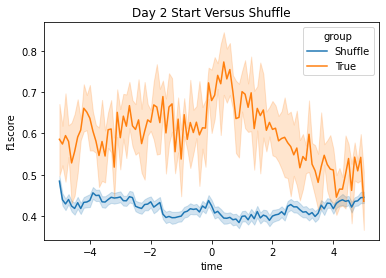

In [138]:
plot_scores(d2_start_true_scores, d2_start_bootstrap_scores)
plt.title("Day 2 Start Versus Shuffle")
plt.savefig(FIG_DIR / "Decoding - D2 Start.svg")
save_scores("Day 2 Start Versus Shuffle", d2_start_true_scores, d2_start_bootstrap_scores, save_data_dir)

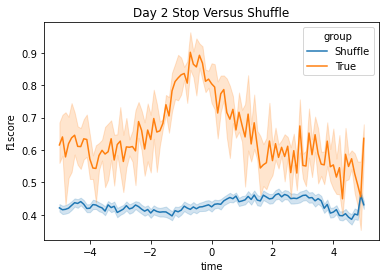

In [139]:
plot_scores(d2_stop_true_scores, d2_stop_bootstrap_scores)
plt.title("Day 2 Stop Versus Shuffle")
plt.savefig(FIG_DIR / "Decoding - D2 Stop.svg")
save_scores("Day 2 Stop Versus Shuffle", d2_stop_true_scores, d2_stop_bootstrap_scores, save_data_dir)

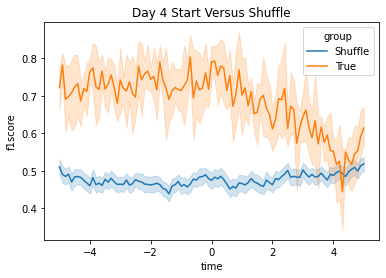

In [140]:
plot_scores(d4_start_true_scores, d4_start_bootstrap_scores)
plt.title("Day 4 Start Versus Shuffle")
plt.savefig(FIG_DIR / "Decoding - D4 Start.svg")
save_scores("Day 4 Start Versus Shuffle", d4_start_true_scores, d4_start_bootstrap_scores, save_data_dir)

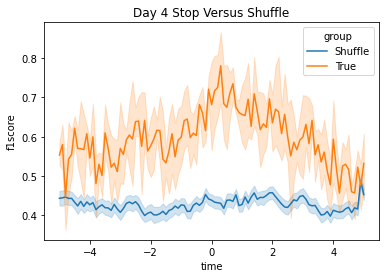

In [141]:
plot_scores(d4_stop_true_scores, d4_stop_bootstrap_scores)
plt.title("Day 4 Stop Versus Shuffle")
plt.savefig(FIG_DIR / "Decoding - D4 Stop.svg")
save_scores("Day 4 Stop Versus Shuffle", d4_stop_true_scores, d4_stop_bootstrap_scores, save_data_dir)

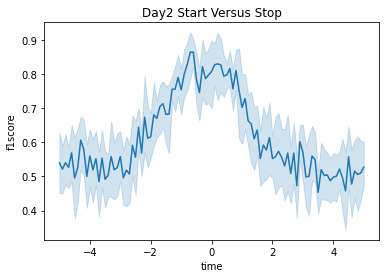

In [145]:
dfp = tidy_true_scores(d2_startstop_res, cv_name="fold")
sns.lineplot(data=dfp, x="time", y="f1score")
plt.title("Day2 Start Versus Stop")
plt.savefig(FIG_DIR / "Decoding - D2 Start Versus Stop.svg")
dfp.to_csv(save_data_dir / "Decoding - True CV scores - Day2 Start Versus Stop.csv")

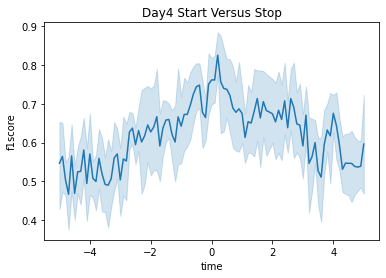

In [146]:
dfp = tidy_true_scores(d4_startstop_res, cv_name="fold")
sns.lineplot(data=dfp, x="time", y="f1score")
plt.title("Day4 Start Versus Stop")
plt.savefig(FIG_DIR / "Decoding - D4 Start Versus Stop.svg")
dfp.to_csv(save_data_dir / "Decoding - True CV scores - Day4 Start Versus Stop.csv")